In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter, accuracy_check_err
import time

In [2]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    x_star, f_star = oracle.getMin()
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape) / 100
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        '''
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)
        '''
        
        error = accuracy_check_err(x_t, x_star)    
        errors.append(error)
         
        itr += 1
        
    return x_t, itr, errors

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i+1, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = 1 / (1 + max(degrees[i], degrees[j]))
                
                W[i, j] = weight
                W[j, i] = weight
    
    for i in range(W.shape[0]):
        if W[i, i] != 0:
            W[i, i] = 1 - (np.sum(W, axis = 0)[i] - 1.0) # Remove 1 because counts self weight of 1 from adjacency matrix W
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))

        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [node, 0]
            else:
                connections[node] = [node, node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        connections[0] = [0]
        for node in range(1, n_nodes):
            connections[node] = [node, 0] # node 0 is central node
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "path":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node != n_nodes - 1:
                connections[node] = [node, node + 1]
            else:
                connections[node] = [node]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, number_exp = 10):
    
    means = []
    results = []
    
    oracle = Oracle(func_type, n_params)
    
    for n_nodes in list_nodes:
        start = time.time()
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        
        for _ in range(number_exp): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            x_t, itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
        
        mean = np.mean(temp)
        
        print(f'DEBUG num.nides {n_nodes} time {time.time() - start}')
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        means.append(mean)
        results.append(temp)
    
    return np.array(means), np.array(results)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

# Experiments

In [3]:
save_folder = "data/"

n_params = 8
max_iter = np.inf
number_exp = 3

num_nodes = [10, 50, 100, 300, 600, 1000]

## Non convex function

In [4]:
func_type = "non convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.09380197525024414
Converged within 2e-05 in 670.3333333333334 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.13056612014770508
Converged within 2e-05 in 666.3333333333334 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.18174099922180176
Converged within 2e-05 in 667.3333333333334 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.7466070652008057
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 2.537576913833618
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 6.552464962005615
Converged within 2e-05 in 667.3333333333334 iterations on average.



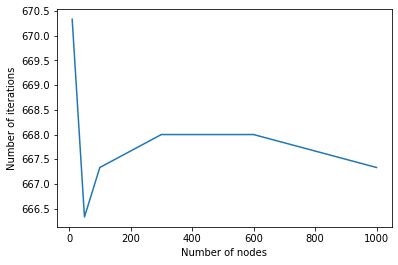

data/nonconvex_dense.npy


In [5]:
topology = "dense"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.1478099822998047
Converged within 2e-05 in 666.3333333333334 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.14221715927124023
Converged within 2e-05 in 667.3333333333334 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.19643020629882812
Converged within 2e-05 in 669.6666666666666 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.6694540977478027
Converged within 2e-05 in 668.3333333333334 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 2.157590866088867
Converged within 2e-05 in 668.6666666666666 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 7.310260772705078
Converged within 2e-05 in 669.0 iterations on average.



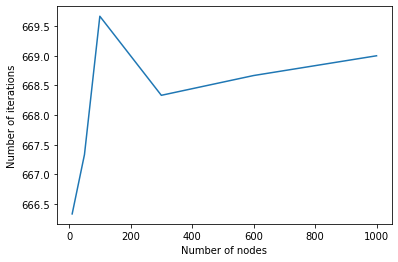

data/nonconvex_ring.npy


In [6]:
topology = "ring"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.2105860710144043
Converged within 2e-05 in 669.6666666666666 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.2156679630279541
Converged within 2e-05 in 671.6666666666666 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.2550468444824219
Converged within 2e-05 in 673.3333333333334 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.69966721534729
Converged within 2e-05 in 675.3333333333334 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 1.9109036922454834
Converged within 2e-05 in 676.3333333333334 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 5.199636936187744
Converged within 2e-05 in 678.3333333333334 iterations on average.



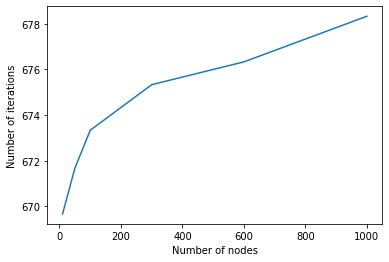

data/nonconvex_centralized.npy


In [7]:
topology = "centralized"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Convex function

In [4]:
func_type = "convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.9993820190429688
Converged within 0.005 in 1629.6666666666667 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 3.153885841369629
Converged within 0.005 in 1626.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 6.1346800327301025
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 13.991991996765137
Converged within 0.005 in 1626.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 31.14053511619568
Converged within 0.005 in 1626.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 50.57642698287964
Converged within 0.005 in 1627.0 iterations on average.



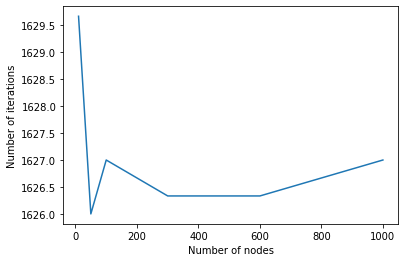

data/convex_dense.npy


In [7]:
topology = "dense"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 1.0648012161254883
Converged within 0.005 in 1625.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.542259931564331
Converged within 0.005 in 1625.6666666666667 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 4.5033042430877686
Converged within 0.005 in 1627.3333333333333 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 13.721038818359375
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 28.099470853805542
Converged within 0.005 in 1626.6666666666667 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 50.55274319648743
Converged within 0.005 in 1627.0 iterations on average.



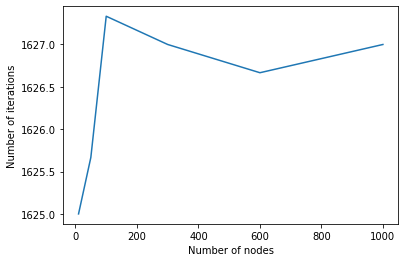

data/convex_ring.npy


In [8]:
topology = "ring"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 1.0420160293579102
Converged within 0.005 in 1628.3333333333333 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.5181150436401367
Converged within 0.005 in 1626.3333333333333 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 5.11016321182251
Converged within 0.005 in 1626.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 14.780253410339355
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 32.23882699012756
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 53.586297273635864
Converged within 0.005 in 1627.0 iterations on average.



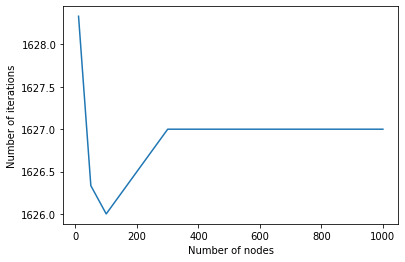

data/convex_centralized.npy


In [9]:
topology = "centralized"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Strongly convex function

In [12]:
func_type = "strongly convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.30187106132507324
Converged within 2e-05 in 315.6666666666667 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.7637267112731934
Converged within 2e-05 in 318.6666666666667 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3680009841918945
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 4.20242714881897
Converged within 2e-05 in 319.6666666666667 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 9.335742950439453
Converged within 2e-05 in 319.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 17.78118920326233
Converged within 2e-05 in 319.0 iterations on average.



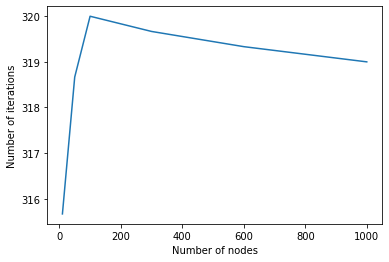

data/stronglyconvex_dense.npy


In [13]:
topology = "dense"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.30213379859924316
Converged within 2e-05 in 324.3333333333333 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.7754092216491699
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3736202716827393
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 3.972280263900757
Converged within 2e-05 in 320.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 8.832770824432373
Converged within 2e-05 in 321.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 16.198559045791626
Converged within 2e-05 in 321.0 iterations on average.



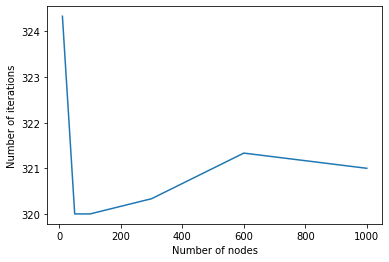

data/stronglyconvex_ring.npy


In [14]:
topology = "ring"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.3198871612548828
Converged within 2e-05 in 322.3333333333333 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.8032069206237793
Converged within 2e-05 in 326.3333333333333 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3906431198120117
Converged within 2e-05 in 326.6666666666667 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 4.096369028091431
Converged within 2e-05 in 330.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 8.931915760040283
Converged within 2e-05 in 331.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 17.105132818222046
Converged within 2e-05 in 331.3333333333333 iterations on average.



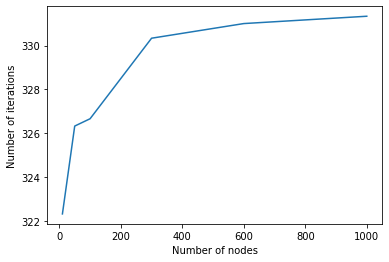

data/stronglyconvex_centralized.npy


In [15]:
topology = "centralized"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

# Plots

In [19]:
def plotError(num_nodes, data, title, names=["Centralized", "Dense", "Ring"]):
    
    plt.figure(figsize=(8, 5)) 
    
    for i, dt in enumerate(data):
        
        means = np.mean(dt, axis=1)
        std = np.std(dt, axis=1)
        
        plt.plot(num_nodes, means, label=names[i], linewidth=3)
        plt.fill_between(num_nodes, means-std, means+std, alpha=0.3)
        
    
    plt.tight_layout()
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.xlabel("Number of nodes", fontsize=18)
    plt.ylabel("Number of iterations", fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.title(title, fontsize=18)
    

## Convex

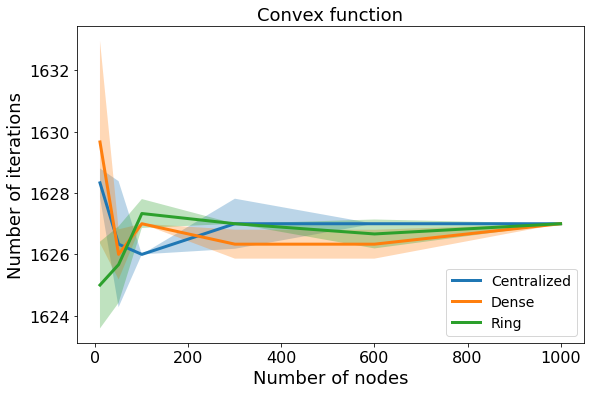

In [20]:
centralized = np.load(save_folder + "convex_centralized.npy")
dense = np.load(save_folder + "convex_dense.npy")
ring = np.load(save_folder + "convex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Convex function")

## Non convex

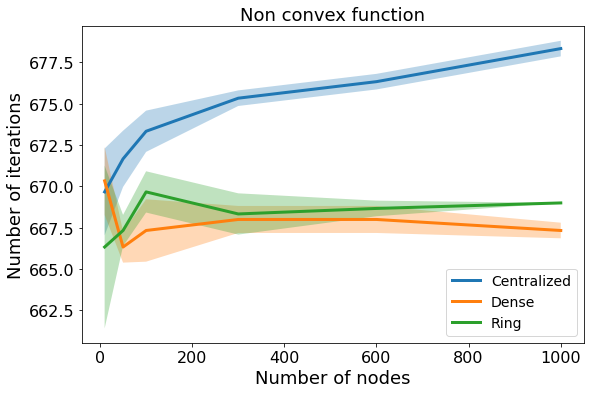

In [22]:
centralized = np.load(save_folder + "nonconvex_centralized.npy")
dense = np.load(save_folder + "nonconvex_dense.npy")
ring = np.load(save_folder + "nonconvex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Non convex function")

## Strongly convex

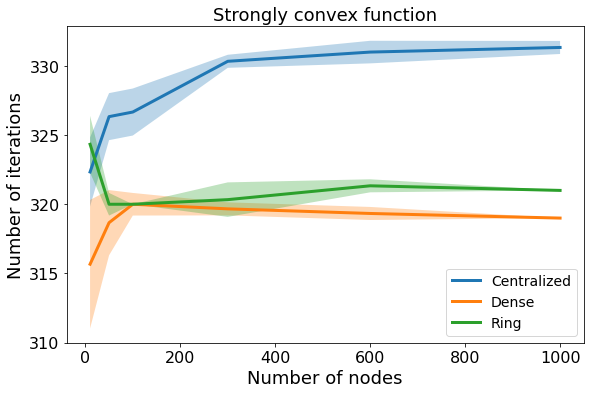

In [24]:
centralized = np.load(save_folder + "stronglyconvex_centralized.npy")
dense = np.load(save_folder + "stronglyconvex_dense.npy")
ring = np.load(save_folder + "stronglyconvex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Strongly convex function")